In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.cuda.set_device(0)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [10]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [11]:
# Create an instance of the model on CUDA
net = LeNet().cuda()

lossvsiter_adadel=[]

# To see if the model is on CUDA or not !
if (next(net.parameters()).is_cuda) :
    print("The model is on CUDA")
else :
    print("The model is on CPU")

import torch.optim as optim

# Declare a loss function
criterion = nn.CrossEntropyLoss()
# Declare an optimizer
optimizer = optim.Adadelta(net.parameters(),lr=0.001)


# No of iterations !
iterations = 25
loss_list = []

for epoch in range(iterations):  # loop over the dataset multiple times
    
    # Reset the loss for the current epoch !
    running_loss = 0.0
    tloss = 0.0
    # Loop over all the mini-batches therea are 12500 mini batches of size 4 each !
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable & if possible make them cuda tensors
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients for the current epoch
        optimizer.zero_grad()
        
        # forward + backward + optimize
        
        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Calculate gradients of whatever variable set to req_gardients = True
        loss.backward()
        
        # Take one step of the gradient descent for this epoch ! 
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        tloss += loss.data[0]
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[Epoch :: %d, Mini Batch :: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            lossvsiter_adadel.append(running_loss / 2000)
            running_loss = 0.0
            
    loss_list.append(tloss)

print('Finished Training')

The model is on CUDA
[Epoch :: 1, Mini Batch ::  2000] loss: 2.304
[Epoch :: 1, Mini Batch ::  4000] loss: 2.303
[Epoch :: 1, Mini Batch ::  6000] loss: 2.300
[Epoch :: 1, Mini Batch ::  8000] loss: 2.299
[Epoch :: 1, Mini Batch :: 10000] loss: 2.296
[Epoch :: 1, Mini Batch :: 12000] loss: 2.292
[Epoch :: 2, Mini Batch ::  2000] loss: 2.283
[Epoch :: 2, Mini Batch ::  4000] loss: 2.276
[Epoch :: 2, Mini Batch ::  6000] loss: 2.267
[Epoch :: 2, Mini Batch ::  8000] loss: 2.252
[Epoch :: 2, Mini Batch :: 10000] loss: 2.235
[Epoch :: 2, Mini Batch :: 12000] loss: 2.214
[Epoch :: 3, Mini Batch ::  2000] loss: 2.185
[Epoch :: 3, Mini Batch ::  4000] loss: 2.163
[Epoch :: 3, Mini Batch ::  6000] loss: 2.139
[Epoch :: 3, Mini Batch ::  8000] loss: 2.117
[Epoch :: 3, Mini Batch :: 10000] loss: 2.095
[Epoch :: 3, Mini Batch :: 12000] loss: 2.082
[Epoch :: 4, Mini Batch ::  2000] loss: 2.044
[Epoch :: 4, Mini Batch ::  4000] loss: 2.044
[Epoch :: 4, Mini Batch ::  6000] loss: 2.028
[Epoch :: 4, 

In [23]:
import pickle
with open("lossvsiter_adadel.pkl","wb") as f:
    pickle.dump(lossvsiter_adadel,f)

In [12]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    try:
        outputs = net(Variable(images))
    except RuntimeError as re:
        print(outputs.is_cuda)
        print(str(re))
        sys.exit()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 39 %


In [25]:
for i, data in enumerate(trainloader, 0):
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    try:
        outputs = net(Variable(images))
    except RuntimeError as re:
        print(outputs.is_cuda)
        print(str(re))
        sys.exit()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    if (i%1000) == 0:
        print(i)

print('Accuracy of the network on the 50000 trained images: %d %%' % (
    100 * correct / total))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
Accuracy of the network on the 50000 trained images: 34 %


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 50 %
Accuracy of   car : 44 %
Accuracy of  bird :  7 %
Accuracy of   cat : 18 %
Accuracy of  deer :  6 %
Accuracy of   dog : 39 %
Accuracy of  frog : 60 %
Accuracy of horse : 46 %
Accuracy of  ship : 32 %
Accuracy of truck : 45 %


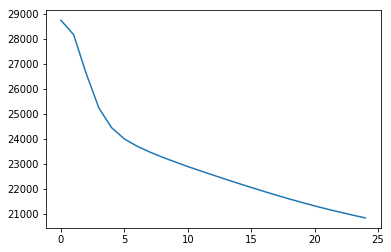

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_list)